In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
''' install the desired pytorch version '''
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 61.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [3]:
''' importing the neccessary libraries '''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import pdb
from math import sqrt, ceil

from torch.autograd import Variable

from PIL import Image

from functools import partial
import sys

import cv2


In [53]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)
batch_size = 32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=False, transform=transform)

print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))

# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`
print(len(train_dataset))
train_size = int(0.9*len(train_dataset))
valid_size = int(0.1*len(train_dataset)) 
print(train_size)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
train_size = len(train_dataset)
valid_size = len(valid_dataset)
print(len(train_dataset))


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(len(train_dataloader)*32)
print(len(valid_dataloader)*32)
print(len(test_dataloader)*32)

device: cuda
Files already downloaded and verified
Files already downloaded and verified
training dataset size: 50000
test dataset size: 10000
50000
45000
45000
45024
5024
10016


In [7]:
#input 224,224,3 image return after unormaliz
#(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    
def unormalize(im):
  r = im[:,:,0] * 0.2023 + 0.4914
  g = im[:,:,1] * 0.1994 + 0.4822
  b = im[:,:,2] * 0.2010 + 0.4465
  new_im = np.zeros(im.shape)
  new_im[:,:,0] = r
  new_im[:,:,1] = g
  new_im[:,:,2] = b
  return new_im

50000
cat
(32, 32, 3)


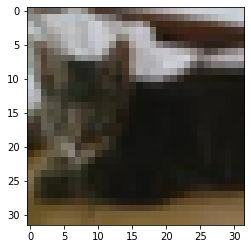

In [26]:
print(len(trainset))
im ,label = trainset[9]
print(classes[label])
im = im.numpy()
im = np.transpose(im,(1,2,0))
im = unormalize(im)
print(im.shape)
#unnormalize
#im = 0.5*im + 0.5
#im = cv2.resize(im,(0,0) , fx = 9,fy = 9)
plt.imshow(im)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


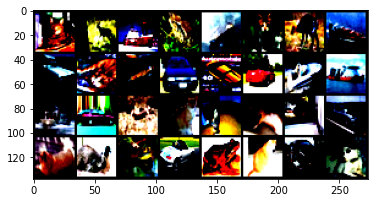

In [9]:
#data exploration
#get random training data
#some data exploration
#helper function for that 
#pytorch has tensor in the format (channel,width,height) whereas numpy has it (width,height,channel)
# So the transformation is (1,2,0) tells the correct format (width,height,channel)
def imshow(img):
  np_image = img.numpy()
  #print(np_image.shape)
  #fig = plt.figure(figsize = (30,30))
  #fig.add_subplot(1,1,1)
  plt.imshow(np.transpose(np_image,(1,2,0)))

data_iter = iter(trainloader)
images, labels = data_iter.next()
#print(len(images))
#print(images[0].shape)

#show the images
imshow(torchvision.utils.make_grid(images))
#note that there are 32 images

CIFAR10 Contains 10 classes,60000 images ,each of size 32 x 32

In [10]:
print(images.shape)

torch.Size([32, 3, 32, 32])


In [42]:
print(len(train_dataloader))
print(len(valid_dataloader))

1407
157


In [34]:
#now the main part ,the code for the actual model
# We use the VGG16 Architecture (Zisserman et al)
class SMAI(nn.Module):
  def __init__(self):
    #not sure exactly how this works.Something to do with inheritance,
    super(SMAI , self).__init__()

    #we use default values of stride = 1
    #and padding = 0
    #our input is (3,32,32) C,H,W
    #set out_channel as 64,so we get 32 kernels in the layer
    # therefore output dimension are (64,32,32) C,H,W
    #self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32 , kernel_size = 3)


    #we want two linear layers
    #first hidden layer
    #self.d1 = nn.Linear(26*26*32,128)
    
    #ouput layer
    # 10 is the output class
    #self.d2 = nn.Linear(128,10)

    #the sequential is a container
    #takes an input 
    #chains the input - output to the next layer
    #returns the final output
    #input BATCH_SIZE * 1 * 28 * 28 for MNIST
    #commenting out some of the maxpooling Blocks to make sure kernel spatial dimension reduces to 7*7 and not below
    self.features = nn.Sequential(
        
        
        
        
     

      nn.Conv2d(3,16,3,padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, stride = 2, return_indices = True) ,

      #output 32,16,16,16

    
      nn.Conv2d(16,32,3,padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, stride = 2, return_indices = True) ,

     #output 32,32,8,8

    
      nn.Conv2d(32,32,3,padding = 1),
      nn.ReLU()
    
    #output 32,32,8,8

    



        
    )

    self.classifier = nn.Sequential(

        
        nn.Linear(2048,128),
        nn.Dropout(p=0.2),

    # Linear layer with 10 output features
        nn.Linear(128,10)

    )

    self.feature_maps = OrderedDict() #used to store all feature maps
    self.max_pooling_locations = OrderedDict() #used to store the location of the values from max pools
    self.Convolution_layers_indices = [0,3,6]
    self.Relu_layers_indices = [1,4,7]
    self.pooling_layers_indices = [2,5]
    
  
  #a function to initialise with a pretrained model
  #has to have the same architecture as the one define above
  #must be compatible with above defined structure of features and classifier
  def initialise_weights(self,model):
    #copy the parameter values for features
    for index,layer in enumerate(model.features):
      #only relevant for learnable parameters,not for Pooling,Relu etc
      if isinstance(layer,nn.conv2d):
        self.features[index].weight.data = layer.weight.data
        self.features[index].bias.data = layer.bias.data
    #copy the parameter values for classifier
    for index,layer in enumerate(model.classifier):
      #only relevant for FC Linear parameters
      if isinstance(layer,nn.Linear):
        self.classifier[index].weight.data = layer.weight.data
        self.classifier[index].bias.data = layer.bias.data

  #function for forward propagation
  def forward(self,x):
    #neccessary for storing the max pool location for inverse pooling
    for index,layer in enumerate(self.features):
      if isinstance(layer,nn.MaxPool2d):
        x, locs = layer(x)
      else:
        x = layer(x)
    #converts a (N,C,H,W) input to (N,C*H*W)
    x = x.view(x.size()[0],-1)
    output = self.classifier(x)
    output = torch.nn.functional.softmax(output,dim = 1)
    return output



In [ ]:
%ls

data/  drive/  sample_data/


[link text](https://)

In [29]:
ep = [0,5,10,15,19,25]

In [61]:
def train(model, device, train_dataloader, optimizer, criterion):
  """trains for one epoch"""
  
  model.train()
  accumulated_loss = 0.0
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)
  for i,data in enumerate(train_dataloader):
    (inputs, labels) = data
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    labels = labels.to(device)
    #print(images.shape)
    #forward pass 
    logits = model(inputs)

    #compute Cross Entropy Loss
    loss = criterion(logits,labels)

    #set the gradients to zero
    optimizer.zero_grad()

    #back prop
    loss.backward()

    #update model parameter
    optimizer.step()
    #print("Progress : {0} / {1} : {2}".format(i + 1,len(train_dataloader),(i + 1)/len(train_dataloader)))

    # YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    # 2. forward the inputs
    # 3. compute the loss
    # 4. backprop the loss
    # 5. update the weights

    # YOUR CODE ENDS HERE

    accumulated_loss += loss.item()
  return torch.div(accumulated_loss , len(train_dataloader))

def test(model, device, dataloader, criterion):
  model.eval()
  accumulated_loss = 0.0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      (inputs, labels) = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # YOUR CODE BEGINS HERE
      # 1. forward the inputs
      # 2. compute the loss
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # YOUR CODE ENDS HERE

      
      accumulated_loss += loss.item()

      predictions = outputs.argmax(dim=1)
      correct += (predictions == labels).sum()

    num_samples = len(dataloader)
    avg_loss = accumulated_loss / num_samples
    accuracy = np.float(correct) / 5000
    print("Average Loss : {0}".format(avg_loss))
    print("Correct : {0} , number_of_samples : {1} and accuracy : {2}".format(correct,5000,accuracy))
    return avg_loss, accuracy
    

In [63]:
model = SMAI().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  print("Epoch : {0}".format(epoch))
  train_loss = train(model, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if epoch in ep:
    print("Saving model for epoch:{0}".format(epoch))
    filename = "./drive/MyDrive/Models/SMAI_MODEL_EPOCH_" + str(epoch + 1) + ".pth"
    torch.save(model.state_dict(), filename)
    

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

Epoch : 0
Average Loss : 2.290065845866112
Correct : 527 , number_of_samples : 5000 and accuracy : 0.1054
Saving model for epoch:0
[1] training loss: 2.30
[1] validation loss: 2.29, validation accuracy: 10.54%

Epoch : 1
Average Loss : 2.1611265809672653
Correct : 1454 , number_of_samples : 5000 and accuracy : 0.2908
[2] training loss: 2.23
[2] validation loss: 2.16, validation accuracy: 29.08%

Epoch : 2
Average Loss : 2.1038005169789504
Correct : 1765 , number_of_samples : 5000 and accuracy : 0.353
[3] training loss: 2.13
[3] validation loss: 2.10, validation accuracy: 35.30%

Epoch : 3
Average Loss : 2.071325467650298
Correct : 1937 , number_of_samples : 5000 and accuracy : 0.3874
[4] training loss: 2.09
[4] validation loss: 2.07, validation accuracy: 38.74%

Epoch : 4
Average Loss : 2.050266886972318
Correct : 2041 , number_of_samples : 5000 and accuracy : 0.4082
[5] training loss: 2.05
[5] validation loss: 2.05, validation accuracy: 40.82%

Epoch : 5
Average Loss : 2.0385653000728

In [20]:
#this is the twin Deconvnet of the above VGG16 called Roy Net
class SMAI_Deconv(nn.Module) :
  def __init__(self):
        super(VGG16_Deconv, self).__init__()
        self.features = nn.Sequential(
          

          nn.ReLU(),
          nn.ConvTranspose2d(32, 32, 3, padding = 1),

          nn.MaxUnpool2d(2, stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16, 3, padding = 1),

          nn.MaxUnpool2d(2, stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 3, 3, padding = 1),
          


        )
        
        #this maps the indices of the layer of in conv net architecture with the deconvnet architecture
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_index_mapping = {0:7 , 3:4 , 6:1}
        #this maps the bias of the conv layer with the deconv layer.For some reason this does not 
        #perfectly allign with above transformation because the first backward layer is randomly set
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_bias_index_mapping = {0:4,3:1}

        #this maps the forward and backward relu layer
        #{forward_ind : backward_ind}
        self.relu_relu_layer_index_mapping = {1:6 , 4:3 , 7:0}

        #this maps the forward maxpool layer index to the backward maxunpool netword
        #{backward_ind : forward}
        self.unmaxpool_maxpool_layer_index_mapping = {5:2, 2:5}

  #this updates the parameters of the deconv model from the passed parameter which is the forward model
  def update_weights(self, model):

    #update the paramters
    for index,layer in enumerate(model.features):
      if isinstance(layer,nn.Conv2d):
        self.features[self.conv_deconv_layer_index_mapping[index]].weight.data = layer.weight.data
        if index in self.conv_deconv_layer_bias_index_mapping:
          self.features[self.conv_deconv_layer_bias_index_mapping[index]].bias.data = layer.bias.data
          #print("do")
  #forward pass to obtain the inverse image
  #pool locs is useful for maxunpooling
  #layer is the index of the layer from which x is passed(I think)
  #I am not too sure
  #The input layer should be a RELU or CONV
  #Not sure why Maxpooling layer not allowed
  def forward(self, x , layer  , pool_locs):
    #print("Forward")
    if layer in self.conv_deconv_layer_index_mapping:
      start_index = self.conv_deconv_layer_index_mapping[layer]
    elif layer in self.relu_relu_layer_index_mapping:
      start_index = self.relu_relu_layer_index_mapping[layer]
    else:
      print("The given layer is not RELU or Conv,exiting")
      #sys.exit(0)
    
    for index in range(start_index,len(self.features)):
      if isinstance(self.features[index] , nn.MaxUnpool2d):
        print("Unpool")
        x = self.features[index](x,pool_locs[self.unmaxpool_maxpool_layer_index_mapping[index]])
      else:
        if isinstance(self.features[index],nn.ConvTranspose2d):
          print("Transpose")
        if isinstance(self.features[index],nn.ReLU):
          print("RElu")
        x = self.features[index](x)
    return x

    







In [21]:
#Function to visualize a feature map in a grid
#feature map is the shape (C,W,H,N)
#this part is I dont understand that well
#utility function for visualization
def visualize_feature_map(feature_map):
  (C,W,H,N) = feature_map.shape
  cnt = int(ceil(sqrt(C)))
  G = np.ones((cnt*H + cnt,cnt*W + cnt,N),feature_map.dtype)#the extra cnt is for black colored spacing
  G *= np.min(feature_map)

  n = 0
  for row in range(cnt):
    for col in range(cnt):
      if n < C:
        #additional cnt for spacing
        G[row*H + row : (row + 1)*H + row, col*W + col : (col + 1)*W + col,:] = feature_map[n,:,:,:]
        n += 1

  #Normalize G
  G = (G - G.min())/(G.max() - G.min())
  return G


#function to visualize a layer represented by a grid
#again do not understand this part much
def visualize_layer(feature_layer_grid):
  plt.clf() #clears figure
  plt.subplot(121)
  plt.imshow(feature_layer_grid[:,:,0],cmap = 'gray')


#transform a deconvolutional image to a normal one(Also normalize)
#input is the output of the deconvolated image
def transform_deconvolved_image(output) :
  d_img = output.data.numpy()[0].transpose(1,2,0) #gets it to (H,W,C) format
  d_img = (d_img - d_img.min())/(d_img.max() - d_img.min()) #normalize
  return d_img.astype(np.uint8)


#function to store all the feature maps and max_pooling locations
def store_all_feature_maps(model):
  #this is a function that is to be passed to another function
  #It will be called everytime forward is called on model
  def hook(module,input,output,key):
    if isinstance(module,nn.MaxPool2d):
      #remember the maxpool layer returns two values x,loc because return_indices is set to true
      model.feature_maps[key] = output[0] #stores the feature map to the ordereddict
      model.max_pooling_locations[key] = output[1] #stores the location
    else:
      model.feature_maps[key] = output
  for index,layer in enumerate(model._modules.get('features')):  
    #register forward hook makes the hook to be called whenever forward is called
    #partial allows hook to be called hook(module,input,output,key = index)
    layer.register_forward_hook(partial(hook,key = index))

  
